## The Darcy's equation
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Deep Generative Neural Operator (DGNO)

### (2.1) Prepare data

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_cts2d'
tag = 'tanhBeta128'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/smh_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/smh_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["sol"][...,n0:n0+ndata]).T, dtype)
    beta1 = np2tensor(np.array(data["beta1"][n0:n0+ndata]), dtype)
    beta2 = np2tensor(np.array(data["beta2"][n0:n0+ndata]), dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    x = gridx.repeat((ndata, 1, 1))
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    
    return a, u, x, gridx, beta1, beta2
#
a_train, u_train, x_train, gridx_train, beta1_train, beta2_train = get_data(data_train, n_train, dtype)
a_test, u_test, x_test, gridx_test, beta1_test, beta2_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('The shape of beta1', beta1_train.shape, 'The shape of beta2', beta2_train.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
print('The shape of beta1', beta1_test.shape, 'The shape of beta2', beta2_test.shape)

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of u_train: torch.Size([1000, 841, 1])
The shape of gridx_train: torch.Size([841, 2])
The shape of beta1 torch.Size([1000, 1]) The shape of beta2 torch.Size([1000, 1])
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])
The shape of beta1 torch.Size([200, 1]) The shape of beta2 torch.Size([200, 1])


### (2.2) Define the loss class

In [2]:
###############################
# Define Loss Class
###############################
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)
#
genPoint = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype)

###############################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0:1])*torch.sin(np.pi * x[...,1:2])
        return u
        
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.fun_a = fun_a
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.model_a = solver.model_dict['a']
        self.mollifer = mollifer()
        #######################
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)

    def Loss_pde(self, a_batch, w_pde, nc=100):
        beta = self.model_enc(a_batch)
        #
        if w_pde>0.:
            n_batch = a_batch.shape[0]
            ############### Data points ###############
            xc, R = genPoint.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
            xc, R = xc.to(self.device), R.to(self.device)
            # 
            x = self.int_grid * R + xc
            #
            x = x.reshape(-1, 2).repeat((n_batch,1,1))
            x = Variable(x, requires_grad=True)
            ############### Test functions #############
            v = self.v.repeat((nc,1,1)).reshape(-1,1)
            dv = (self.dv_dr / R).reshape(-1, 2)
            ################ model prediction ###########
            a_detach = self.fun_a(x.detach(), a_batch) 
            u = self.model_u(x, beta)
            u = self.mollifer(u, x)
            du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            # 
            f = 10. * torch.ones_like(u)
            ################ PDE loss ####################  
            left = torch.sum( a_detach*du*dv, dim=-1).reshape(n_batch, nc, self.n_grid)
            left = torch.mean(left, dim=-1)
            # 
            right = (f * v).reshape(n_batch, nc, self.n_grid)
            right = torch.mean(right, dim=-1)
            ################################################
            res = (left-right)**2
            res, indices = torch.sort(res.flatten(), descending=True, dim=0)
            loss_res = torch.sum( res[0:100*10] )

            return self.solver.getLoss(left, right) + loss_res 
        else:
            return torch.tensor(0.)
        
    def Loss_data(self, x, a, u, w_data):
        beta = self.model_enc(a)
        a_pred = self.model_a(x, beta)
        ############# The reconstruction loss
        loss_a = self.solver.getLoss(a_pred, a)
        
        return loss_a

    def Error(self, x, a, u):
        beta = self.model_enc(a)
        u_pred = self.model_u(x, beta)
        u_pred = self.mollifer(u_pred, x)

        return self.solver.getError(u_pred, u)

######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' # for u model
beta_size = 128     
#
fun_a = solver.getModel_a(Exact_a=None, approximator='RBF', 
                          **{'x_mesh':gridx_train, 'kernel':'gaussian', 
                             'eps':25., 'smoothing':0., 'degree':6.})
####################################### The beta model
from Networks.EncoderNet import EncoderCNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv='SiLU', activation_fc='SiLU',
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.tanh(x)
        
        return x

conv_arch = [1, 64, 64, 64]
fc_arch = [64*2*2, 128, 128, beta_size]
model_enc = Encoder(conv_arch, fc_arch, nx_size=res, ny_size=res, 
                    dtype=dtype).to(device)
###################################### The u model
hidden_list, act_x, act_a = [80]*6, 'Tanh_Sin', 'Tanh_Sin'
model_u = solver.getModel(x_in_size=2, a_in_size=beta_size, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)
model_a = solver.getModel(x_in_size=2, a_in_size=beta_size, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType=netType)
# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
########
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

int_grid shape: torch.Size([45, 2]) v shape: torch.Size([45, 1])
140,416 training parameters.
88,332 training parameters.
228,748 total parameters


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u, 'a':model_a, 'enc':model_enc}
solver.train_setup(model_dict, lr=5e-4, optimizer='AdamW', scheduler_type='StepLR', 
                   gamma=0.6, step_size=200)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0.25, w_pde=1., batch_size=50, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/DGNO_{tag}/'})

  0%|                                                                         | 0/1000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  5%|███▏                                                            | 50/1000 [01:25<27:03,  1.71s/it]

Epoch:50 Time:85.9690, loss:69.7507, loss_pde:69.4214, loss_data:1.3171
                l2_test:0.0830, lr:0.0005


 10%|██████▎                                                        | 100/1000 [02:51<25:38,  1.71s/it]

Epoch:100 Time:171.4514, loss:47.4107, loss_pde:47.1401, loss_data:1.0825
                l2_test:0.0379, lr:0.0005


 15%|█████████▍                                                     | 150/1000 [04:16<24:13,  1.71s/it]

Epoch:150 Time:256.9878, loss:43.1211, loss_pde:42.8728, loss_data:0.9934
                l2_test:0.0658, lr:0.0005


 20%|████████████▌                                                  | 200/1000 [05:42<22:48,  1.71s/it]

Epoch:200 Time:342.5221, loss:33.2128, loss_pde:32.9681, loss_data:0.9786
                l2_test:0.0332, lr:0.0003


 25%|███████████████▊                                               | 250/1000 [07:08<21:23,  1.71s/it]

Epoch:250 Time:428.0947, loss:29.0001, loss_pde:28.8064, loss_data:0.7748
                l2_test:0.0247, lr:0.0003


 30%|██████████████████▉                                            | 300/1000 [08:33<19:58,  1.71s/it]

Epoch:300 Time:513.6328, loss:18.0055, loss_pde:17.8331, loss_data:0.6894
                l2_test:0.0407, lr:0.0003


 35%|██████████████████████                                         | 350/1000 [09:59<18:31,  1.71s/it]

Epoch:350 Time:599.1820, loss:21.1512, loss_pde:20.9874, loss_data:0.6555
                l2_test:0.0207, lr:0.0003


 40%|█████████████████████████▏                                     | 400/1000 [11:24<17:05,  1.71s/it]

Epoch:400 Time:684.6800, loss:22.5282, loss_pde:22.3851, loss_data:0.5724
                l2_test:0.0350, lr:0.00017999999999999998


 45%|████████████████████████████▎                                  | 450/1000 [12:50<15:41,  1.71s/it]

Epoch:450 Time:770.2919, loss:13.5302, loss_pde:13.4546, loss_data:0.3023
                l2_test:0.0122, lr:0.00017999999999999998


 50%|███████████████████████████████▌                               | 500/1000 [14:15<14:14,  1.71s/it]

Epoch:500 Time:855.8033, loss:12.5589, loss_pde:12.4463, loss_data:0.4503
                l2_test:0.0157, lr:0.00017999999999999998


 55%|██████████████████████████████████▋                            | 550/1000 [15:41<12:50,  1.71s/it]

Epoch:550 Time:941.2953, loss:9.3201, loss_pde:9.2381, loss_data:0.3280
                l2_test:0.0106, lr:0.00017999999999999998


 60%|█████████████████████████████████████▊                         | 600/1000 [17:06<11:24,  1.71s/it]

Epoch:600 Time:1026.8339, loss:10.1816, loss_pde:10.0933, loss_data:0.3533
                l2_test:0.0115, lr:0.00010799999999999998


 65%|████████████████████████████████████████▉                      | 650/1000 [18:32<09:57,  1.71s/it]

Epoch:650 Time:1112.3245, loss:15.2035, loss_pde:15.1040, loss_data:0.3979
                l2_test:0.0141, lr:0.00010799999999999998


 70%|████████████████████████████████████████████                   | 700/1000 [19:57<08:32,  1.71s/it]

Epoch:700 Time:1197.7367, loss:9.3897, loss_pde:9.3227, loss_data:0.2679
                l2_test:0.0115, lr:0.00010799999999999998


 75%|███████████████████████████████████████████████▎               | 750/1000 [21:23<07:06,  1.71s/it]

Epoch:750 Time:1283.1315, loss:10.0399, loss_pde:9.9682, loss_data:0.2869
                l2_test:0.0143, lr:0.00010799999999999998


 80%|██████████████████████████████████████████████████▍            | 800/1000 [22:48<05:41,  1.71s/it]

Epoch:800 Time:1368.4572, loss:8.6290, loss_pde:8.5458, loss_data:0.3329
                l2_test:0.0123, lr:6.479999999999999e-05


 85%|█████████████████████████████████████████████████████▌         | 850/1000 [24:13<04:15,  1.70s/it]

Epoch:850 Time:1453.7980, loss:7.9929, loss_pde:7.9399, loss_data:0.2120
                l2_test:0.0084, lr:6.479999999999999e-05


 90%|████████████████████████████████████████████████████████▋      | 900/1000 [25:39<02:50,  1.71s/it]

Epoch:900 Time:1539.0481, loss:5.8777, loss_pde:5.8233, loss_data:0.2177
                l2_test:0.0102, lr:6.479999999999999e-05


 95%|███████████████████████████████████████████████████████████▊   | 950/1000 [27:04<01:25,  1.70s/it]

Epoch:950 Time:1624.2936, loss:6.0149, loss_pde:5.9586, loss_data:0.2255
                l2_test:0.0099, lr:6.479999999999999e-05


100%|██████████████████████████████████████████████████████████████| 1000/1000 [28:29<00:00,  1.71s/it]

Epoch:1000 Time:1709.5371, loss:5.7047, loss_pde:5.6458, loss_data:0.2356
                l2_test:0.0077, lr:3.8879999999999994e-05
The total training time is 1709.5565


#### (2.3.2) make prediction

The shape of a_test: torch.Size([200, 841, 1]) a_pred: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1]) u_pred: torch.Size([200, 841, 1])
The shape of beta_pred: torch.Size([200, 128])
The test l2 error (u avg): tensor(0.0077)
The test l2 error (a avg): tensor(0.0032)


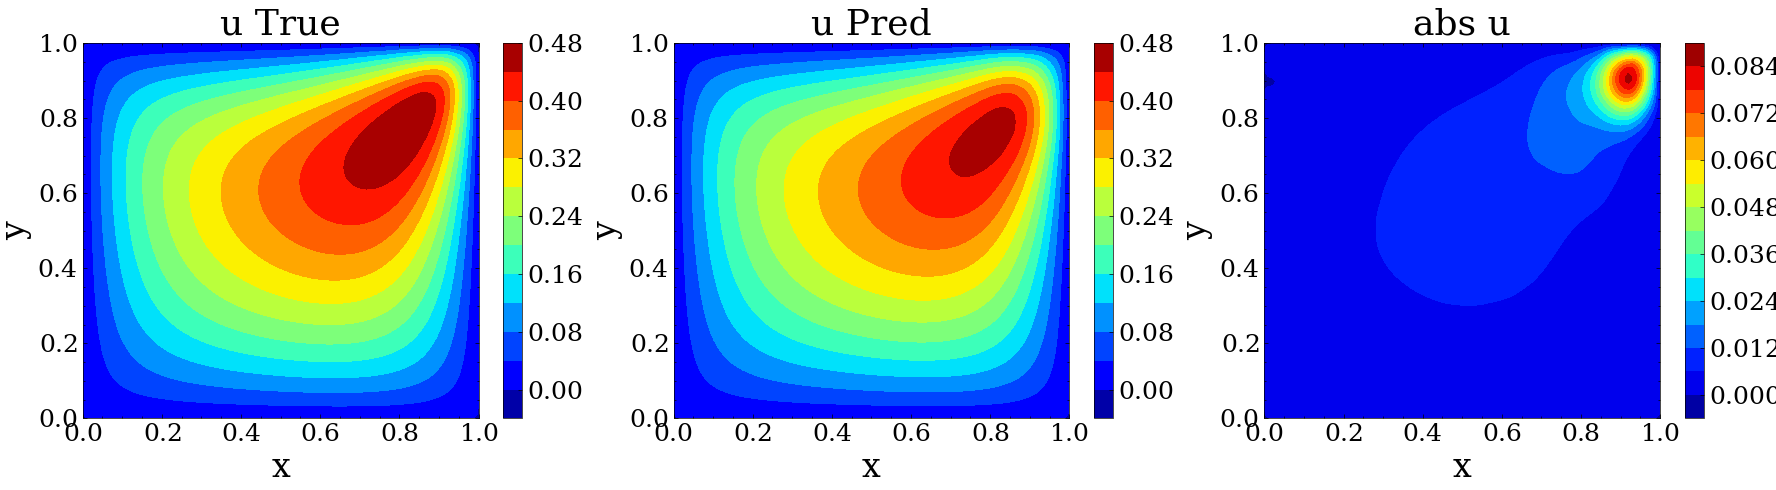

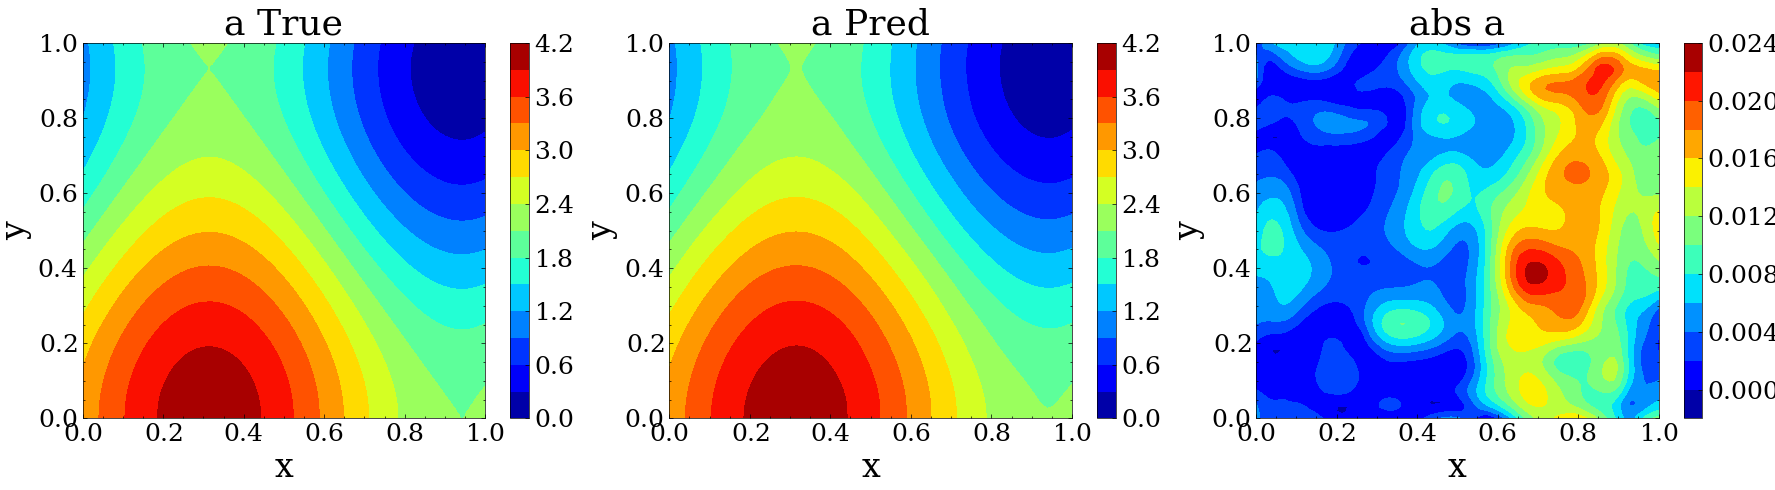

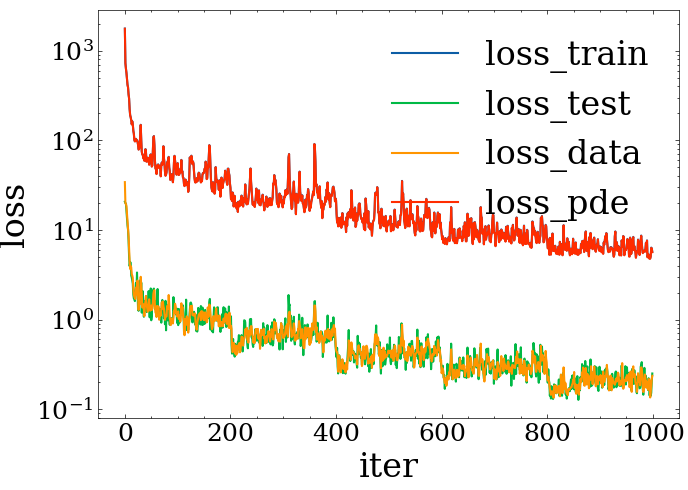

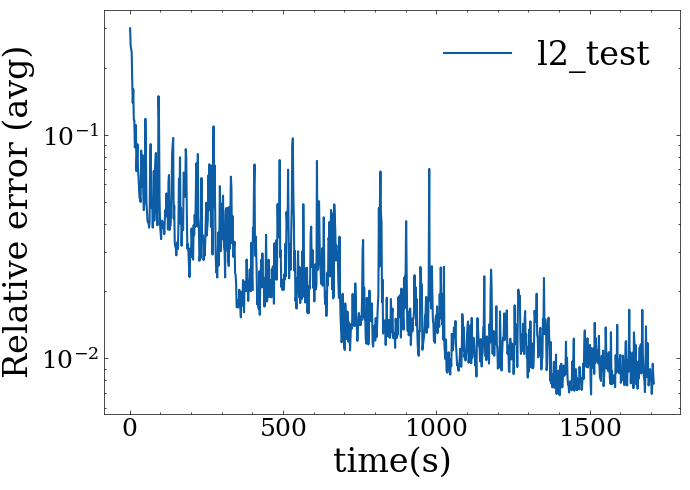

In [3]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
tag = 'tanhBeta128'
model_trained = solver.loadModel(path=f'saved_models/DGNO_{tag}/', 
                                 name=f'model_dgno_final')
inx = 0
#########################################
x_coe = gridx_train.repeat(a_test.shape[0], 1, 1).to(device)
x_var = Variable(x_test, requires_grad=True).to(device)
beta_pred = model_trained['enc'](a_test.to(device))
u_pred = model_trained['u'](x_var, beta_pred)
a_pred = model_trained['a'](x_coe, beta_pred)
u_pred = mollifer()(u_pred, x_var).detach().cpu()
a_pred = a_pred.detach().cpu()
beta_pred = beta_pred.detach().cpu()
#
print('The shape of a_test:', a_test.shape, 'a_pred:', a_pred.shape)
print('The shape of u_test:', u_test.shape, 'u_pred:', u_pred.shape)
print('The shape of beta_pred:', beta_pred.shape)
print('The test l2 error (u avg):', solver.getError(u_pred, u_test))
print('The test l2 error (a avg):', solver.getError(a_pred, a_test))
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx_test, [u_test[inx], u_pred[inx], abs(u_pred[inx]-u_test[inx])],
                 ['u True', 'u Pred', 'abs u'], lb=0.)
Plot.show_2d_list(gridx_train, [a_test[inx], a_pred[inx], abs(a_pred[inx]-a_test[inx])],
                 ['a True', 'a Pred', 'abs a'], lb=0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_{tag}/', name='loss_dgno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])

### (2.3.3) The latent beta and recoved a

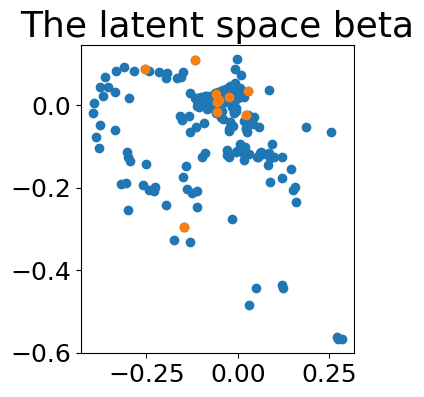

In [4]:
from Utils.Losses import *

#################################### Plot the latent beta space
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
#
ax1.scatter(beta_pred[:,0], beta_pred[:,1])
ax1.scatter(beta_pred[inx:inx+10,0], beta_pred[inx:inx+10,1])
ax1.set_title('The latent space beta')
plt.show()